# 1. Table Manipulation
We will retrieve our dataset from GitHub, define the predictor variables (X) and the response variable (Y), and partition the data into training and testing sets.

We will start with the model representing the transition from naturalized (0) to invasive (1).

In [12]:
import pandas as pd
import numpy as np

d = pd.read_table("https://github.com/Thiieres/Caatinga_Invasive_Plants_ML/blob/main/nonnative_plant_caatinga_ML.txt?raw=True")

d = d.loc[d["stat"] != "exo"]
dados_y = d[['stat']]
dados_X = d.loc[:, 'LA':]
dados_y["stat"] = dados_y["stat"].replace({'nat': 0, 'inv': 1})
dados_y.head(), dados_X.head()

/tmp/ipython-input-2922570374.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dados_y["stat"] = dados_y["stat"].replace({'nat': 0, 'inv': 1})
/tmp/ipython-input-2922570374.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dados_y["stat"] = dados_y["stat"].replace({'nat': 0, 'inv': 1})


(   stat
 0     0
 1     1
 3     0
 4     0
 6     1,
             LA        SM         H         MPD      PDmin       MPDw  \
 0  7665.237837    7.4388  3.040096  264.121225  44.549292  12.628515   
 1   275.000000  119.8050  6.562000  227.699207  51.060340  12.124991   
 3   878.350805    0.1600  0.429000  244.514967  65.087106  30.202390   
 4  3332.678074    0.1940  1.500000  246.086692  65.087105   8.861959   
 6   675.000000    2.5584  3.500000  254.405195   5.904980   9.703608   
 
    Bio.1.native  Bio.10.native  Bio.11.native  Bio.12.native  ...  \
 0     23.797575      25.912865      21.193934    1060.952381  ...   
 1     25.274598      29.280467      20.651719    1150.881295  ...   
 3     11.377488      19.012068       4.019588     869.859638  ...   
 4     24.121413      25.089241      23.094658    1998.747748  ...   
 6     23.406877      26.539870      19.371783     612.103896  ...   
 
    Bio.18.diff  Bio.19.diff  Bio.2.diff  Bio.3.diff  Bio.4.diff  Bio.5.diff  \
 0 

In [ ]:
d.shape

(120, 53)

In [ ]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

# Splitting data into training and testing sets, stratified by invasion status
X_train, X_test, y_train, y_test = train_test_split(
    dados_X, dados_y,
    test_size=0.3,
    random_state=42,
    stratify=dados_y
)

# Checking class distribution in training and testing sets
print(y_train.value_counts(), y_test.value_counts())

# Applying SMOTE to balance classes in the training set
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

# Checking dimensions and new class distribution
print(X_train.shape, y_train.shape)
print(y_train.value_counts(), y_test.value_counts())

stat
0       53
1       31
Name: count, dtype: int64 stat
0       23
1       13
Name: count, dtype: int64
(106, 49) (106, 1)
stat
0       53
1       53
Name: count, dtype: int64 stat
0       23
1       13
Name: count, dtype: int64


# 2. Variables selection with RandomForest

In [ ]:
# RandomForest
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

rf_model = RandomForestClassifier(random_state=42) # creating the ML model here
scores_rf = cross_val_score(rf_model, X_train, y_train.values.ravel(), cv=5, scoring='roc_auc')
print(scores_rf)

[0.84297521 0.85       0.82272727 0.94545455 1.        ]


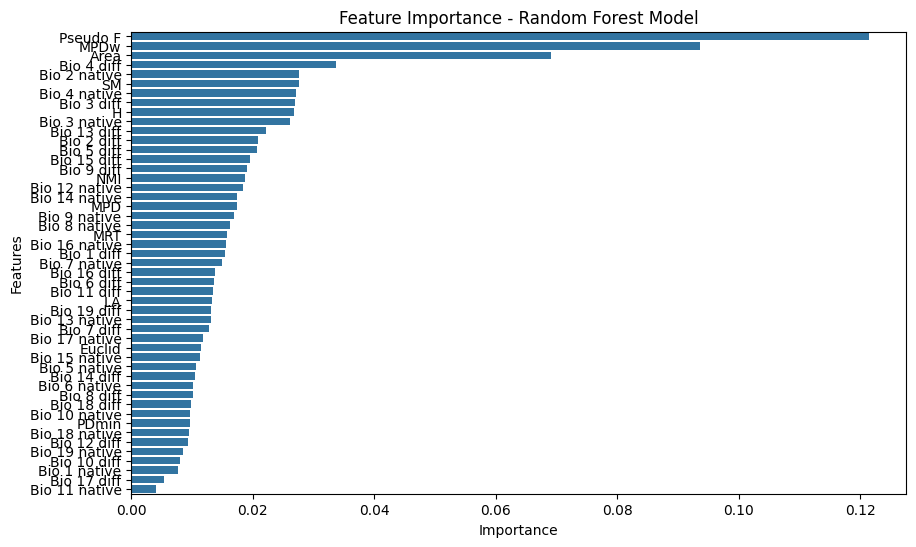

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

rf_model.fit(X_train, y_train.values.ravel())
# Getting feature importances
importances = rf_model.feature_importances_
feature_names = X_train.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plotting feature importances
plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df, x='Importance', y='Feature')
plt.title('Feature Importance - Random Forest Model')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

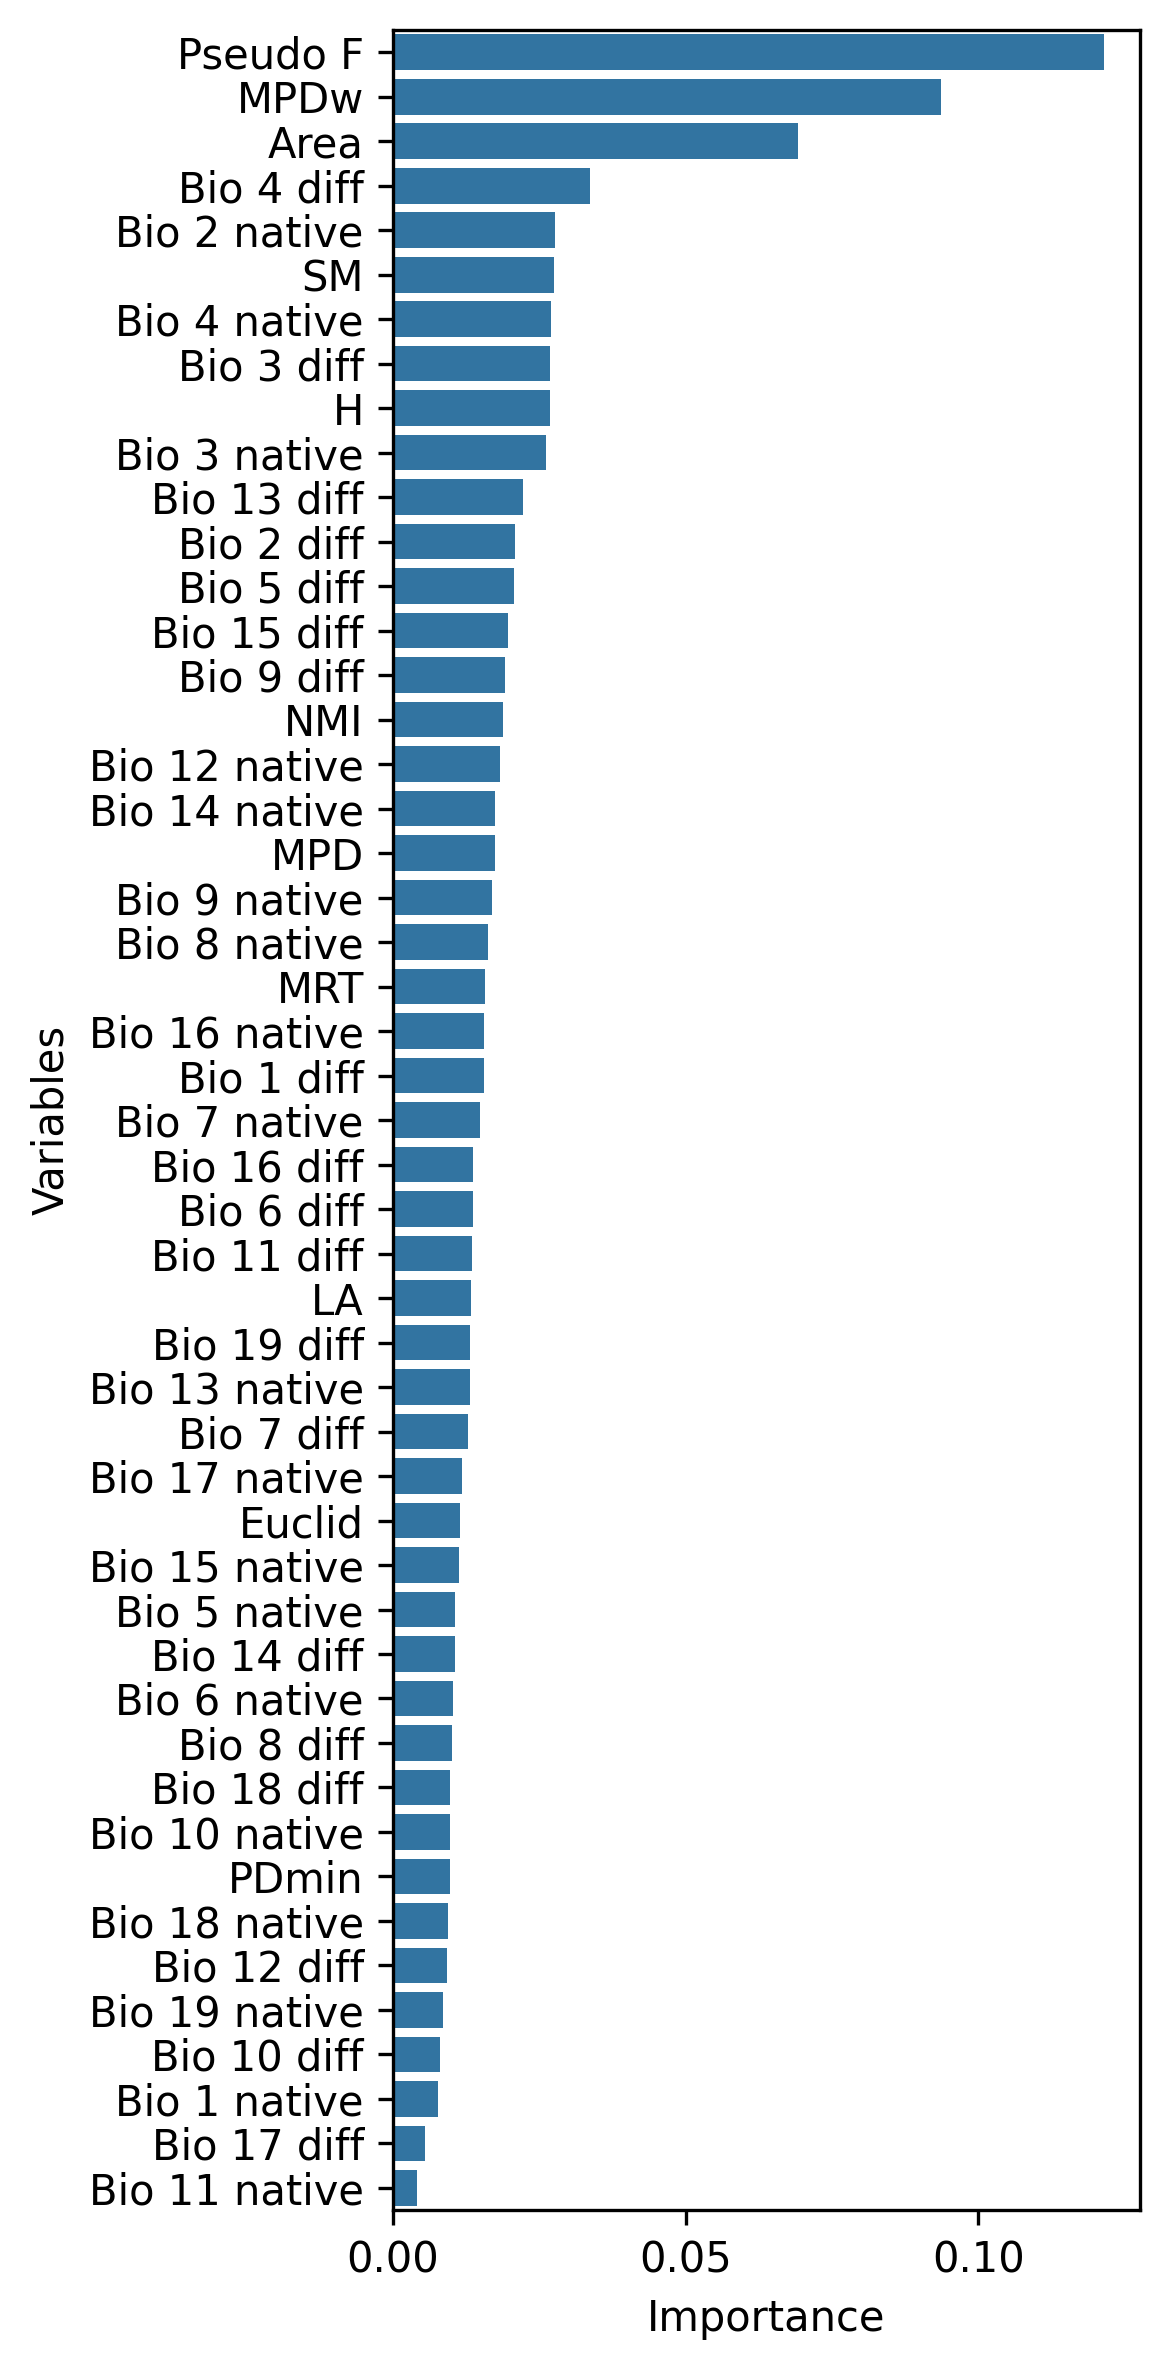

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import files

# Plotting feature importances
plt.figure(figsize=(4, 8), dpi=300)  # Set DPI for higher quality
sns.barplot(data=importance_df, x='Importance', y='Feature')
plt.xlabel('Importance')
plt.ylabel('Variables')
plt.tight_layout() # Adjust layout to prevent labels from being cut off
plt.savefig('importance_invasion.pdf') # Save the plot as a PDF file
plt.show()

files.download('importance_invasion.pdf')

To identify the most informative predictors, we constructed models and evaluated their performance using different subsets of variables ranked according to their relative importance.

The optimal subset of variables was then selected based on predictive performance, while additional marginal subsets were tested to allow fine-tuning of the model.

In [ ]:
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

def evaluate_model_with_top_features(model, X_train, y_train, X_test, y_test, top_n_features):
  """
  Trains and evaluates a model with the top 'n' features.
  Returns the average recall, F1, and accuracy.
  """
  model.fit(X_train, y_train.values.ravel())
  y_pred = model.predict(X_test)
  recall = recall_score(y_test, y_pred)
  f1 = f1_score(y_test, y_pred)
  accuracy = accuracy_score(y_test, y_pred)
  auc = roc_auc_score(y_test, y_pred)
  return recall, f1, accuracy, auc

# List of the number of features to test
top_n_features_list = [1, 2, 3, 5, 10, 15, 20, 25, 30, 35]

# Dictionaries to store the results
results = {}

# Loop to test each number of features
for top_n in top_n_features_list:
  # Selecting the top_n most important features
  top_features = importance_df['Feature'].head(top_n).tolist()
  X_train_subset = X_train[top_features]
  X_test_subset = X_test[top_features]

  # Training and evaluating the model with the selected features
  recall, f1, accuracy, auc = evaluate_model_with_top_features(rf_model, X_train_subset, y_train, X_test_subset, y_test, top_n)
  results[top_n] = {'recall': recall, 'f1': f1, 'accuracy': accuracy, "AUC":auc}

# Printing the results
for top_n, metrics in results.items():
  print(f"With the top {top_n} features:")
  print(f"  Recall: {metrics['recall']:.4f}")
  print(f"  F1: {metrics['f1']:.4f}")
  print(f"  Accuracy: {metrics['accuracy']:.4f}")
  print(f"  AUC: {metrics['AUC']:.4f}")

With the top 1 features:
  Recall: 0.6154
  F1: 0.5161
  Accuracy: 0.5833
  AUC: 0.5903
With the top 2 features:
  Recall: 0.5385
  F1: 0.5385
  Accuracy: 0.6667
  AUC: 0.6388
With the top 3 features:
  Recall: 0.6923
  F1: 0.6667
  Accuracy: 0.7500
  AUC: 0.7375
With the top 5 features:
  Recall: 0.5385
  F1: 0.5385
  Accuracy: 0.6667
  AUC: 0.6388
With the top 10 features:
  Recall: 0.5385
  F1: 0.5600
  Accuracy: 0.6944
  AUC: 0.6605
With the top 15 features:
  Recall: 0.4615
  F1: 0.5000
  Accuracy: 0.6667
  AUC: 0.6221
With the top 20 features:
  Recall: 0.4615
  F1: 0.5217
  Accuracy: 0.6944
  AUC: 0.6438
With the top 25 features:
  Recall: 0.5385
  F1: 0.5600
  Accuracy: 0.6944
  AUC: 0.6605
With the top 30 features:
  Recall: 0.4615
  F1: 0.5217
  Accuracy: 0.6944
  AUC: 0.6438
With the top 35 features:
  Recall: 0.4615
  F1: 0.5217
  Accuracy: 0.6944
  AUC: 0.6438


In [ ]:
# We aim to rank these variable subsets based on AUC and recall values in order to identify the most effective combinations of predictors.

results_df = pd.DataFrame.from_dict(results, orient='index')
results_df['features'] = results_df.index.map(lambda x: importance_df['Feature'].head(x).tolist())
results_df = results_df.sort_values(by=['AUC', 'recall'], ascending=False)
results_df.head(5)

,recall,f1,accuracy,AUC,features
3,0.692308,0.666667,0.750000,0.737458,"[Pseudo F, MPDw, Area]"
10,0.538462,0.560000,0.694444,0.660535,"[Pseudo F, MPDw, Area, Bio 4 diff, Bio 2 nativ..."
25,0.538462,0.560000,0.694444,0.660535,"[Pseudo F, MPDw, Area, Bio 4 diff, Bio 2 nativ..."
20,0.461538,0.521739,0.694444,0.643813,"[Pseudo F, MPDw, Area, Bio 4 diff, Bio 2 nativ..."
30,0.461538,0.521739,0.694444,0.643813,"[Pseudo F, MPDw, Area, Bio 4 diff, Bio 2 nativ..."


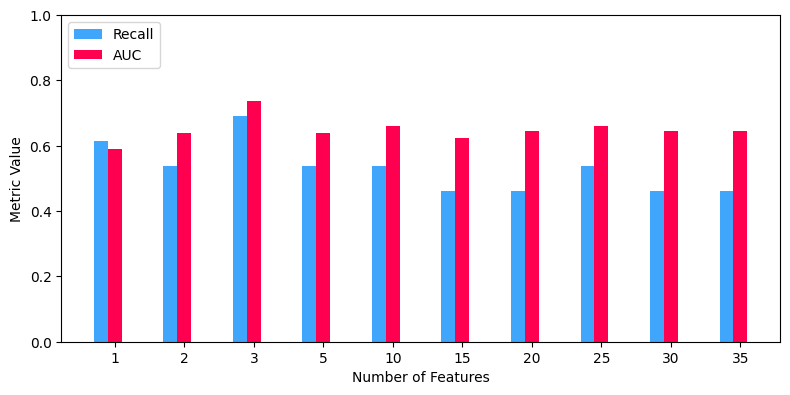

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# We aim to visualize the performance of each variable subset using a grouped bar plot, with different colors representing each metric (AUC and recall).

# Create a DataFrame from the results dictionary
results_df = pd.DataFrame.from_dict(results, orient='index')

# Reset index to make 'top_n' a column
results_df = results_df.reset_index()

# Rename the 'index' column to 'Number of Features'
results_df = results_df.rename(columns={'index': 'Number of Features'})

# Create a grouped bar plot
plt.figure(figsize=(8, 4))
bar_width = 0.2

# Define the x-axis positions for each group
x_positions = np.arange(len(results_df['Number of Features']))

# Plot each metric with a different color and label
plt.bar(x_positions - bar_width, results_df['recall'], width=bar_width, label='Recall', color='#40a6fb')
plt.bar(x_positions, results_df['AUC'], width=bar_width, label='AUC', color='#ff0051')

# Customize the plot
plt.xlabel('Number of Features')
plt.ylabel('Metric Value')
plt.xticks(x_positions, results_df['Number of Features'])
plt.legend(loc='upper left')
plt.tight_layout()
plt.ylim(0, 1)
plt.savefig('subsets_invasion.pdf') # Save the plot as a PDF file
plt.show()

from google.colab import files
files.download('subsets_invasion.pdf')

In [ ]:
# We selected the top 3, 10, and 30 most important variables based on their relative importance scores.
top_3_features = importance_df['Feature'].head(3).tolist()
top_25_features = importance_df['Feature'].head(25).tolist()
top_10_features = importance_df['Feature'].head(10).tolist()


# Training and testing datasets were then filtered to include only these subsets of predictors.
X_train_3 = X_train[top_3_features]
X_test_3 = X_test[top_3_features]
X_train_25 = X_train[top_25_features]
X_test_25 = X_test[top_25_features]
X_train_10 = X_train[top_10_features]
X_test_10 = X_test[top_10_features]

print("selected variables:", top_3_features)
print("selected variables:", top_10_features)
print("selected variables:", top_25_features)


selected variables: ['Pseudo F', 'MPDw', 'Area']
selected variables: ['Pseudo F', 'MPDw', 'Area', 'Bio 4 diff', 'Bio 2 native', 'SM', 'Bio 4 native', 'Bio 3 diff', 'H', 'Bio 3 native']
selected variables: ['Pseudo F', 'MPDw', 'Area', 'Bio 4 diff', 'Bio 2 native', 'SM', 'Bio 4 native', 'Bio 3 diff', 'H', 'Bio 3 native', 'Bio 13 diff', 'Bio 2 diff', 'Bio 5 diff', 'Bio 15 diff', 'Bio 9 diff', 'NMI', 'Bio 12 native', 'Bio 14 native', 'MPD', 'Bio 9 native', 'Bio 8 native', 'MRT', 'Bio 16 native', 'Bio 1 diff', 'Bio 7 native']


In [ ]:
# We have subsets containing the top 3, 5, and 10 most important variables. We aim to apply GridSearch for each subset to identify the optimal hyperparameters and obtain performance metrics, including recall, F1-score, accuracy, and AUC, for each subset using its respective best parameters.

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score

def perform_gridsearch_and_evaluate(model, param_grid, X_train, y_train, X_test, y_test):
  """
  Performs GridSearchCV and returns evaluation metrics for the best model.
  """
  grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='recall', cv=5)
  grid_search.fit(X_train, y_train.values.ravel())

  best_model = grid_search.best_estimator_
  y_pred = best_model.predict(X_test)

  recall = recall_score(y_test, y_pred)
  f1 = f1_score(y_test, y_pred)
  accuracy = accuracy_score(y_test, y_pred)
  y_pred_proba = best_model.predict_proba(X_test)[:, 1]
  auc = roc_auc_score(y_test, y_pred_proba)

  return recall, f1, accuracy, auc, best_model, grid_search.best_params_


# Define the model and GridSearchCV for each set of variables
rf_model = RandomForestClassifier(random_state=42)
param_grid = {
    'n_estimators': [25, 50, 100, 150, 200],
    'max_depth': [None, 2, 5, 7, 10],
    'min_samples_split': [2, 5, 10]
}

# Apply GridSearchCV and evaluate the model for each set of variables
results_3 = perform_gridsearch_and_evaluate(rf_model, param_grid, X_train_3, y_train, X_test_3, y_test)
results_25 = perform_gridsearch_and_evaluate(rf_model, param_grid, X_train_25, y_train, X_test_25, y_test)
results_10 = perform_gridsearch_and_evaluate(rf_model, param_grid, X_train_10, y_train, X_test_10, y_test)



In [ ]:
# Print the results
print("Results with 3 variables:")
print(f"  Recall: {results_3[0]:.4f}")
print(f"  AUC: {results_3[3]:.4f}")
print(f"  Best Parameters: {results_3[5]}")
print("\nResults with 10 variables:")
print(f"  Recall: {results_10[0]:.4f}")
print(f"  AUC: {results_10[3]:.4f}")
print(f"  Best Parameters: {results_10[5]}")
print("\nResults with 25 variables:")
print(f"  Recall: {results_25[0]:.4f}")
print(f"  AUC: {results_25[3]:.4f}")
print(f"  Best Parameters: {results_25[5]}")


Results with 3 variables:
  Recall: 0.7692
  AUC: 0.8328
  Best Parameters: {'max_depth': 7, 'min_samples_split': 2, 'n_estimators': 25}

Results with 10 variables:
  Recall: 0.5385
  AUC: 0.7843
  Best Parameters: {'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 25}

Results with 25 variables:
  Recall: 0.5385
  AUC: 0.7993
  Best Parameters: {'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 150}


The subset containing the three variables proved to be the most appropriate, improving all performance metrics. We will proceed with F_pres, mds_weighted, and area_p.

3. Initial Model Training, Fine-Tuning, and Validation

In [ ]:
##Getting the X data for training and testing already filtered with our three variables
## ['F_pres', 'mpds_weighted', 'Area_p']

X_train = X_train[['Pseudo F', 'MPDw', 'Area']]
X_test = X_test[['Pseudo F', 'MPDw', 'Area']]
X_train.head(),X_test.head()

(    Pseudo F       MPDw         Area
 0  39.860114   8.786791  433841.0455
 1   4.808158  19.857665  285202.6450
 2   4.225788  22.237862  337366.1880
 3  39.206331   7.791478  805377.1469
 4  12.822890   8.107097  791861.5265,
       Pseudo F       MPDw         Area
 47   30.029026   9.057279  679391.5924
 34    4.300793   8.526887  728299.0776
 41   38.081545  11.917088  565008.9902
 115   3.560702   8.526590  635628.6833
 3    47.155581  30.202390  485949.5055)

In [ ]:
###RandomForest
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import randint, uniform

# RandomForest parameters
rf_model = RandomForestClassifier(random_state=42)

param_rf = {
    'n_estimators': [25,30,45,50,100,150, 200,250,300,350],
    'max_depth': [None, 2, 4, 6, 8, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 3, 4, 5]}



# CatBoost
!pip install catboost
from catboost import CatBoostClassifier

# CatBoost parameters
cat_model = CatBoostClassifier(random_state=42, verbose=0)

param_cat = {
    'depth': [4, 6, 8, 10],                       # Tree depth, adjusting model complexity
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3], # Learning rate, controlling model adjustment speed
    'iterations': [50, 100, 200, 500, 1000],      # Number of trees to train
    'l2_leaf_reg': [1, 3, 5, 7, 9],               # L2 regularization for leaves, helping to control overfitting
    'border_count': [32, 64, 128, 255],           # Number of splits for numerical features, adjusting binning
    'bagging_temperature': [0.0, 0.2, 0.5, 1.0],  # Random sampling control; higher values increase tree diversity
    'random_strength': [0.0, 0.2, 0.5, 1.0]}       # Randomness control in node splitting


# XgBoost
from xgboost import XGBClassifier

# Xgboost parameters
xgb_model = XGBClassifier(random_state=42)

param_xgb = {
    'n_estimators': [25,30,45,50,100,150, 200,250,300,350],
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
    'max_depth': [None, 2, 4, 6, 8, 10],
    'min_child_weight': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'reg_alpha': [0, 0.001, 0.01, 0.1, 1, 10, 100],
    'reg_lambda': [0, 0.001, 0.01, 0.1, 1, 10, 100]}

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 11.3 MB/s eta 0:00:00


# RandomForest finetuning




In [ ]:
from sklearn.model_selection import RandomizedSearchCV
search_rf = RandomizedSearchCV(rf_model, param_distributions=param_rf,
                              n_iter=200, cv=5,scoring='recall', random_state=42)

search_rf.fit(X_train, y_train.values.ravel())
rf_params = search_rf.best_params_
print("Best recall:", search_rf.best_score_)
print("Best parameters:",search_rf.best_params_)

Best recall: 0.909090909090909
Best parameters: {'n_estimators': 45, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_depth': None}


In [ ]:
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score


##Tuned model with the best parameters
rf_model = RandomForestClassifier(n_estimators= 45,
                                  min_samples_split= 5,
                                  min_samples_leaf= 3,
                                  max_depth= None,
                                  random_state=42)

rf_model.fit(X_train, y_train.values.ravel())

scores_rf = cross_val_score(rf_model, X_train, y_train.values.ravel(), cv=5, scoring='recall')
print("recall with best parameters (CV):", scores_rf)

recall with best parameters (CV): [0.90909091 0.81818182 0.81818182 1.         1.        ]


In [ ]:
# Making predictions on the test set
y_pred_rf = rf_model.predict(X_test)

# Evaluating the model on the test set
report_rf = classification_report(y_test, y_pred_rf)
print(report_rf)

              precision    recall  f1-score   support

           0       0.82      0.78      0.80        23
           1       0.64      0.69      0.67        13

    accuracy                           0.75        36
   macro avg       0.73      0.74      0.73        36
weighted avg       0.75      0.75      0.75        36



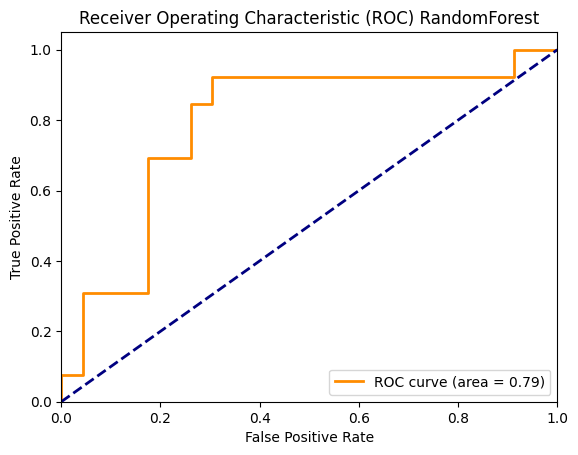

AUC for Random Forest: 0.7892976588628763


In [ ]:
# We aim to generate a ROC curve and calculate the corresponding AUC for this prediction.
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Predict probabilities for the positive class
y_pred_proba_rf = rf_model.predict_proba(X_test)[:, 1]

# Compute ROC curve and AUC
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, y_pred_proba_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

# Plot ROC curve
plt.figure()
plt.plot(fpr_rf, tpr_rf, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_rf)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) RandomForest')
plt.legend(loc="lower right")
plt.show()

print(f"AUC for Random Forest: {roc_auc_rf}")

# CatBoost finetunning

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

search_cat = RandomizedSearchCV(cat_model, param_distributions=param_cat,
                                n_iter=200, cv=5,scoring='recall', random_state=42, n_jobs = -1)
search_cat.fit(X_train, y_train.values.ravel())
cat_params = search_cat.best_params_
print("Best recall:", search_cat.best_score_)
print("Best parameters:",search_cat.best_params_)

Best recall: 0.9272727272727274
Best parameters: {'random_strength': 1.0, 'learning_rate': 0.2, 'l2_leaf_reg': 9, 'iterations': 200, 'depth': 10, 'border_count': 255, 'bagging_temperature': 0.2}


In [ ]:
##Tuned model with the best parameters
cat_model = CatBoostClassifier(random_strength = 1,
                               learning_rate = 0.2,
                               l2_leaf_reg = 9,
                               iterations = 200,
                               depth = 10,
                               border_count = 255,
                               bagging_temperature = 0.2,
                               random_state = 42,
                               verbose = False)

cat_model.fit(X_train, y_train.values.ravel())

scores_cat = cross_val_score(cat_model, X_train, y_train.values.ravel(), cv=5, scoring='recall')
print("recall with best parameters (CV):", scores_cat)

recall with best parameters (CV): [0.81818182 0.90909091 0.90909091 1.         1.        ]


In [ ]:
# Making predictions on the test set
y_pred_cat = cat_model.predict(X_test)

# Evaluating the model on the test set
report_cat = classification_report(y_test, y_pred_cat)
print(report_cat)

              precision    recall  f1-score   support

           0       0.76      0.70      0.73        23
           1       0.53      0.62      0.57        13

    accuracy                           0.67        36
   macro avg       0.65      0.66      0.65        36
weighted avg       0.68      0.67      0.67        36



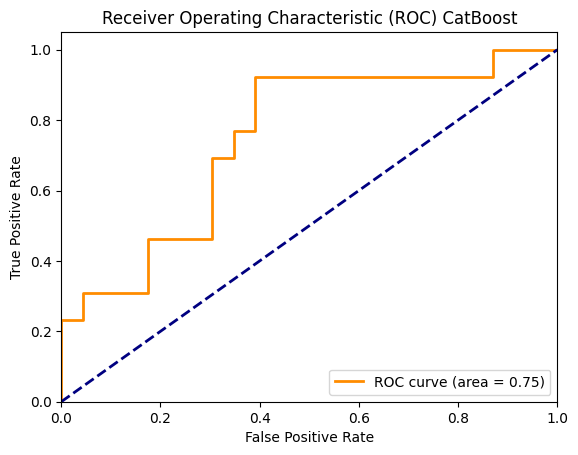

AUC for CatBoost: 0.7458193979933111


In [ ]:
# Predict probabilities for the positive class
y_pred_proba_cat = cat_model.predict_proba(X_test)[:, 1]

# Compute ROC curve and AUC
fpr_cat, tpr_cat, thresholds_cat = roc_curve(y_test, y_pred_proba_cat)
roc_auc_cat = auc(fpr_cat, tpr_cat)

# Plot ROC curve
plt.figure()
plt.plot(fpr_cat, tpr_cat, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_cat)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) CatBoost')
plt.legend(loc="lower right")
plt.show()

print(f"AUC for CatBoost: {roc_auc_cat}")

# XGBoost finetunning

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
xgb_model
search_xgb = RandomizedSearchCV(xgb_model, param_distributions=param_xgb,
                                n_iter=200, cv=5,scoring='recall', random_state=42, n_jobs = -1)
search_xgb.fit(X_train, y_train.values.ravel())
xgb_params = search_xgb.best_params_
print("Best recall:", search_xgb.best_score_)
print("Best parameters:",search_xgb.best_params_)

Best recall: 1.0
Best parameters: {'subsample': 0.6, 'reg_lambda': 0.1, 'reg_alpha': 0.001, 'n_estimators': 350, 'min_child_weight': 15, 'max_depth': 4, 'learning_rate': 0.1, 'gamma': 0.4, 'colsample_bytree': 0.9}


In [ ]:
# We aim to visualize the results of search_xgb, including all hyperparameter combinations tested.
results_df_xgb = pd.DataFrame(search_xgb.cv_results_)

print(results_df_xgb[['params', 'mean_test_score']])
from google.colab import files

results_df_xgb.to_csv('results_df_xgb.csv', encoding = 'utf-8-sig')
files.download('results_df_xgb.csv')

                                                params  mean_test_score
0    {'subsample': 1.0, 'reg_lambda': 0.01, 'reg_al...         0.794545
1    {'subsample': 0.9, 'reg_lambda': 0.001, 'reg_a...         0.400000
2    {'subsample': 0.6, 'reg_lambda': 0, 'reg_alpha...         0.400000
3    {'subsample': 0.8, 'reg_lambda': 1, 'reg_alpha...         0.400000
4    {'subsample': 0.9, 'reg_lambda': 10, 'reg_alph...         0.776364
..                                                 ...              ...
195  {'subsample': 0.8, 'reg_lambda': 0, 'reg_alpha...         0.400000
196  {'subsample': 0.7, 'reg_lambda': 0.01, 'reg_al...         0.794545
197  {'subsample': 0.6, 'reg_lambda': 0.001, 'reg_a...         1.000000
198  {'subsample': 0.7, 'reg_lambda': 0, 'reg_alpha...         0.600000
199  {'subsample': 0.6, 'reg_lambda': 0.1, 'reg_alp...         0.400000

[200 rows x 2 columns]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#original second best set of parameters
from xgboost import XGBClassifier
##Tuned model with the best parameters
xgb_model = XGBClassifier(subsample = 1,
                          reg_lambda = 0.1,
                          reg_alpha = 0,
                          n_estimators = 25,
                          min_child_weight = 1,
                          max_depth = 8,
                          learning_rate = 0.2,
                          gamma = 0.3,
                          colsample_bytree = 0.7,
                          random_state = 42)



xgb_model.fit(X_train, y_train.values.ravel())
from sklearn.model_selection import cross_val_score
scores_xgb = cross_val_score(xgb_model, X_train, y_train.values.ravel(), cv=5, scoring='recall')
print("recall with best parameters (CV):", scores_xgb)

recall with best parameters (CV): [0.72727273 0.81818182 0.72727273 1.         1.        ]


In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
# Making predictions on the test set
y_pred_xgb = xgb_model.predict(X_test)

# Evaluating the model on the test set
report_xgb = classification_report(y_test, y_pred_xgb)
print(report_xgb)

              precision    recall  f1-score   support

           0       0.83      0.87      0.85        23
           1       0.75      0.69      0.72        13

    accuracy                           0.81        36
   macro avg       0.79      0.78      0.79        36
weighted avg       0.80      0.81      0.80        36



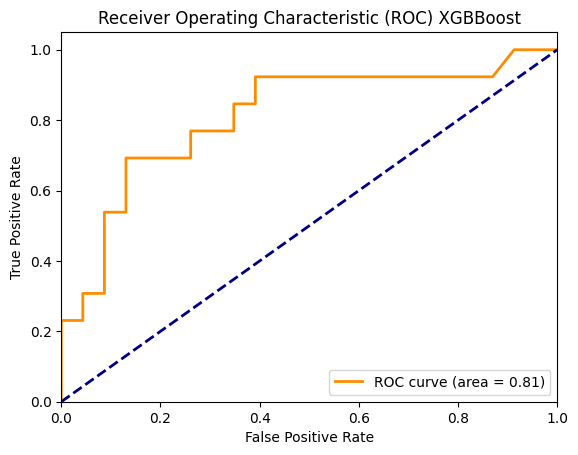

AUC for XGBoost: 0.8110367892976589


In [ ]:
import matplotlib.pyplot as plt
# Predict probabilities for the positive class
y_pred_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]

# Compute ROC curve and AUC
fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(y_test, y_pred_proba_xgb)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

# Plot ROC curve
plt.figure()
plt.plot(fpr_xgb, tpr_xgb, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_xgb)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) XGBBoost')
plt.legend(loc="lower right")
plt.show()

print(f"AUC for XGBoost: {roc_auc_xgb}")

In [ ]:
print(f"AUC for RandomForest: {roc_auc_rf}")
print(f"AUC for CatBoost: {roc_auc_cat}")
print(f"AUC for XGBoost: {roc_auc_xgb}")

AUC for RandomForest: 0.7892976588628763
AUC for CatBoost: 0.7458193979933111
AUC for XGBoost: 0.8110367892976589


In [ ]:
print("XGB",report_xgb)
print("RF",report_rf)
print("CAT",report_cat)

XGB               precision    recall  f1-score   support

           0       0.83      0.87      0.85        23
           1       0.75      0.69      0.72        13

    accuracy                           0.81        36
   macro avg       0.79      0.78      0.79        36
weighted avg       0.80      0.81      0.80        36

RF               precision    recall  f1-score   support

           0       0.82      0.78      0.80        23
           1       0.64      0.69      0.67        13

    accuracy                           0.75        36
   macro avg       0.73      0.74      0.73        36
weighted avg       0.75      0.75      0.75        36

CAT               precision    recall  f1-score   support

           0       0.76      0.70      0.73        23
           1       0.53      0.62      0.57        13

    accuracy                           0.67        36
   macro avg       0.65      0.66      0.65        36
weighted avg       0.68      0.67      0.67        36



In [ ]:
# We aim to calculate the True Skill Statistic (TSS) for each algorithm.

from sklearn.metrics import roc_auc_score

# Assuming you have y_test and y_pred_proba for each model (rf, cat, xgb)

def calculate_tss(y_true, y_pred_proba):
  """Calculates the True Skill Statistic (TSS)."""
  fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
  roc_auc = auc(fpr, tpr)
  tss = roc_auc * 2 - 1
  return tss

# Calculate TSS for each model
tss_rf = calculate_tss(y_test, y_pred_proba_rf)
tss_cat = calculate_tss(y_test, y_pred_proba_cat)
tss_xgb = calculate_tss(y_test, y_pred_proba_xgb)

print(f"TSS for Random Forest: {tss_rf}")
print(f"TSS for CatBoost: {tss_cat}")
print(f"TSS for XGBoost: {tss_xgb}")

TSS for Random Forest: 0.5785953177257526
TSS for CatBoost: 0.4916387959866222
TSS for XGBoost: 0.6220735785953178


# 5. Shap Values

In [ ]:
# We aim to use XGBoost to predict all of our data (dados_X) and to calculate SHAP values for feature interpretation.

import shap
from sklearn.metrics import classification_report

X = dados_X[['Pseudo F', 'MPDw', 'Area']]
y = dados_y
# Predict using the ensemble model on all data
y_pred_xgb_all = xgb_model.predict(X)

reportxgb = classification_report(y, y_pred_xgb_all)
print(reportxgb)

# Calculate SHAP values for the ensemble model
explainer = shap.Explainer(xgb_model, X)
shap_values = explainer(X)

              precision    recall  f1-score   support

           0       0.94      0.95      0.94        76
           1       0.91      0.89      0.90        44

    accuracy                           0.93       120
   macro avg       0.92      0.92      0.92       120
weighted avg       0.92      0.93      0.92       120



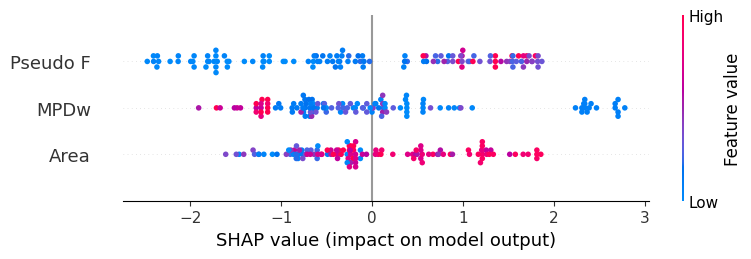

In [ ]:
shap.summary_plot(shap_values, X)

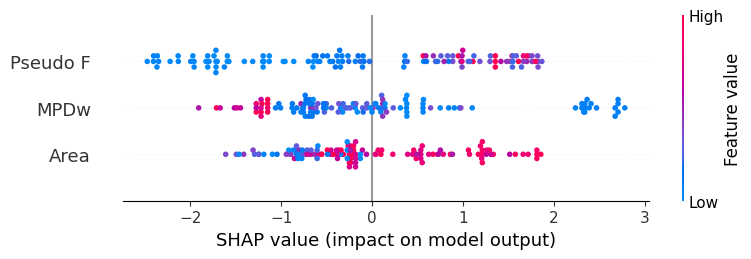

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import matplotlib.pyplot as plt

# Save the summary plot to a PDF file
shap.summary_plot(shap_values, X, show=False)  # show=False prevents immediate display
plt.savefig("summary_plot.pdf")
plt.show() # if you still want to display the plot in the notebook
from google.colab import files
files.download('summary_plot.pdf')

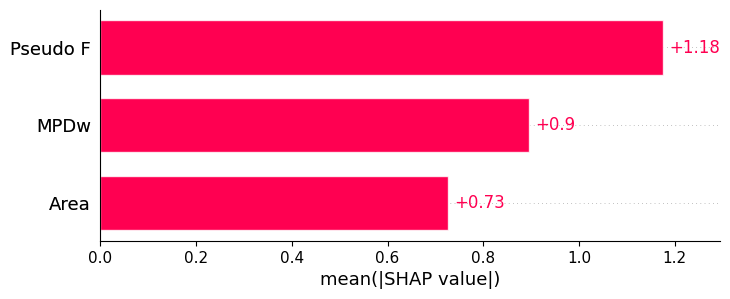

In [ ]:
shap.plots.bar(shap_values)

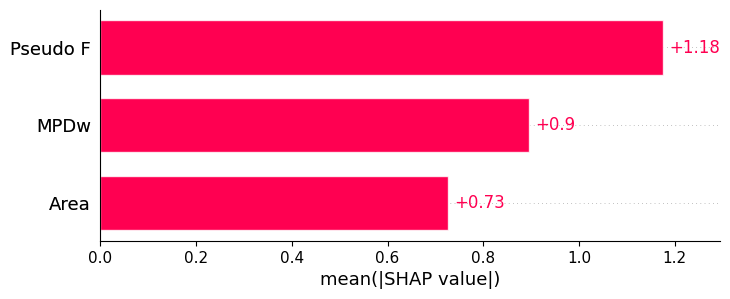

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import matplotlib.pyplot as plt
# Save the summary plot to a PDF file
shap.plots.bar(shap_values, show=False)
plt.savefig("explanation_plot.pdf")
plt.show() # if you still want to display the plot in the notebook
from google.colab import files
files.download('explanation_plot.pdf')

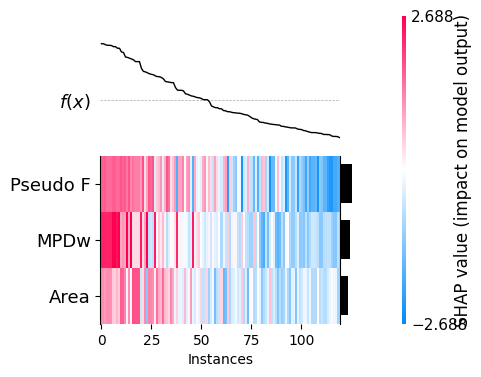

<Axes: xlabel='Instances'>

In [ ]:
shap.plots.heatmap(shap_values, instance_order=shap_values.sum(1))

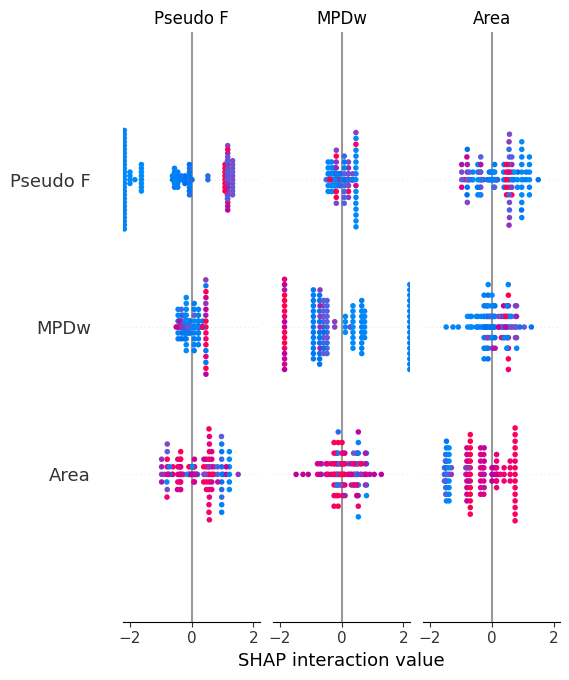

In [ ]:
# We aim to generate a SHAP interaction plot between two variables.

# Assuming iteraction effects for 'F_pres' and 'mpds_weighted'
ex2 = shap.TreeExplainer(xgb_model)
shap_values2 = ex2.shap_interaction_values(X)
shap_interaction_values = ex2.shap_interaction_values(X)

# Plot the interaction effect between 'F_pres' and 'mpds_weighted'
shap.summary_plot(shap_interaction_values, X)

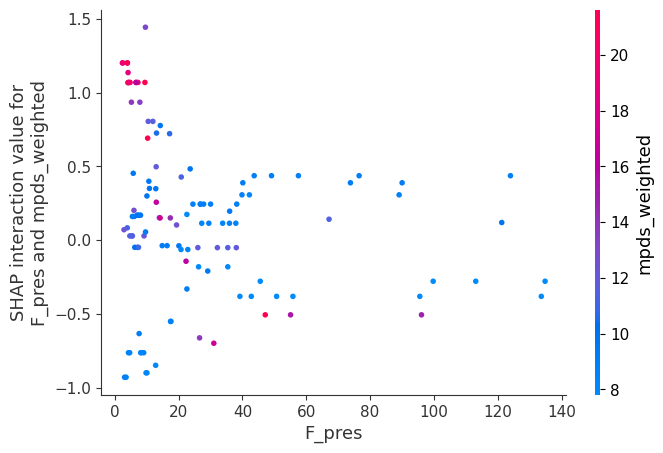

In [ ]:
shap.dependence_plot(("F_pres", "mpds_weighted"), shap_interaction_values, X)

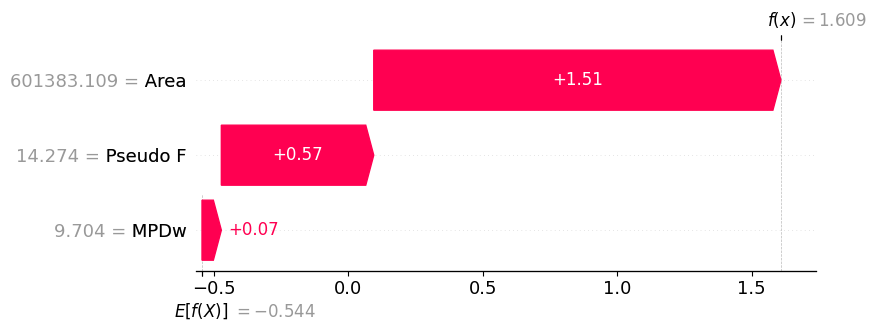

In [ ]:
shap.plots.waterfall(shap_values[4])

In [ ]:
shap_values.values[3]

array([ 1.05733688,  2.40904094, -0.55421774])

In [ ]:
shap_values.base_values[3] + sum(shap_values.values[3])

np.float64(2.3683302266286046)

In [ ]:
# We aim to compute the expression shap_values.base_values[3] + sum(shap_values.values[3]) for indices ranging from 1 to 120.
results = []
for i in range(120):
  result = shap_values.base_values[i] + sum(shap_values.values[i])
  results.append(result)

In [ ]:
shapheat = pd.DataFrame(
    np.c_[shap_values.data, shap_values.values],
    columns = list(X.columns) + list(X.columns))

In [ ]:
# We aim to concatenate the columns y_pred_xgb_all and results.

# Concatenate y_pred_xgb_all and results into a new DataFrame
concatenated_df = pd.concat(
    [pd.DataFrame(results),
     pd.DataFrame(y_pred_xgb_all, columns=['pred_xgb']),
     pd.DataFrame(shapheat)],
    axis=1
)
# Print the concatenated DataFrame
concatenated_df

from google.colab import files
concatenated_df.to_csv('results_shap_invasion.csv', encoding = 'utf-8-sig', index=False)
files.download('results_shap_invasion.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>